In [68]:
%reload_ext autoreload
%autoreload 2

In [69]:

import math
import os
from sklearn.model_selection import train_test_split
import skimage.color as color
import numpy as np
np.set_printoptions(suppress=True)
from colors import ColorsCorpusReader
import colorsys

from transformers import pipeline
from torch_deep_neural_classifier import TorchDeepNeuralClassifier

# pipeline = pipeline('feature-extraction', model='xlnet-base-cased')
pipeline = pipeline('feature-extraction', model='gpt2')


COLORS_SRC_FILENAME = os.path.join("data", "colors", "filteredCorpus.csv")


## Class to hold target color and text

In [70]:


def return_color(rgb_c) :
    lab = color.rgb2lab(np.asarray(rgb_c ))
    lab[0] = lab[0] /100.0 * 2.0 - 1.0
    lab[1] = lab[1] /127.0
    lab[2] = lab[2] /127.0
    return lab

def represent_color_context(lab_cs):

    color_arr = np.asarray(lab_cs)
    max_arr   = np.argmax(color_arr, axis=0)   
    min_arr   = np.argmin(color_arr, axis=0) 
    # brightness offset
    # color_arr[           : ,0] =  0.0
    # color_arr[  max_arr[0] ,0] =  1.0
    # color_arr[  min_arr[0] ,0] = -1.0

    # no brightness offset
    color_arr[           : ,0] =  0.0
    color_arr[  max_arr[0] ,0] =  0.0
    color_arr[  min_arr[0] ,0] =  0.0



    return color_arr

def represent_color(lab,d_model):
    a    = np.pi
    size = d_model - 1 


    c = [ np.dot( lab , [1.0,np.cos(a*t/size),np.sin(a*t/size)] ) for t  in range(0,d_model,1) ]
    return np.array(c)

class ColorDataset() :



    def __init__(self,exs,d_model=128) :

        self.d_model = d_model
        # print(f"embedding dimension for a color :{self.d_model}")

        # turns a set of 3 rgb colors into 3 lab colors in context
        lab_colors      = lambda rgb_colors : represent_color_context( [ return_color(rgb_color) for rgb_color in rgb_colors] ) 

        # turns a set of 3 lab colors into 3 lab embeddings (each d_model dimensions)
        lab_embeddings  = lambda lab_colors : [ represent_color(lab_color,d_model) for lab_color in lab_colors ] 

        # retrieves hls colors and text list from examples
        all_hls_colors, self.texts  = zip(*[[ex.colors, ex.contents] for ex in exs])


        # llm embeddings
        self.llm_data = [ pipeline(text)  for text in self.texts ] 

        # converts hls colors to rgb colors
        all_rgb_colors            = [ [colorsys.hls_to_rgb(*color) for color in colors] for colors in all_hls_colors]

        # converts rgb colors to lab colors
        all_lab_colors            = [ lab_colors(rgb_colors) for rgb_colors in all_rgb_colors]

        # converts lab colors to lab embeddings
        all_lab_embeddings        = [ lab_embeddings(lab_colors) for lab_colors in all_lab_colors]

        # selects the target embedding correspnding to the target text
        self.target_embeddings           = [ lab_embeddings[2] for lab_embeddings in all_lab_embeddings] 

        # selects the target rgb color corresponding to the target text
        self.target_rgbs                 = [ rgb_colors[2]     for rgb_colors     in all_rgb_colors    ] 

        print(f"number of examples     :{len(self.texts)}" )


  

## Create datasets with embedding and text

- dataset.target_embeddings[0]
- dataset.target_rgbs[0]
- dataset.texts[0]

In [71]:

corpus   = ColorsCorpusReader(COLORS_SRC_FILENAME,word_count=None, normalize_colors=True)
examples = list(corpus.read())

EMB_SIZE           = 128 

far_examples  =  [ex for ex in examples if ex.condition == "far" ]
# split_examples = [ex for ex in examples if ex.condition == "split" ]
# close_examples = [ex for ex in examples if ex.condition == "close" ]


far_train  , far_test   = train_test_split(far_examples  ,train_size=.8)
# close_train, close_test = train_test_split(close_examples,train_size=.8)
# split_train, split_test = train_test_split(split_examples,train_size=.8)

far_train_ds, far_test_ds     = ColorDataset(far_train,d_model=EMB_SIZE) , ColorDataset(far_test,d_model=EMB_SIZE)
# close_train_ds, close_test_ds = ColorDataset(split_train,d_model=EMB_SIZE),ColorDataset(close_test,d_model=EMB_SIZE) 
# split_train_ds, split_test_ds = ColorDataset(close_train,d_model=EMB_SIZE), ColorDataset(split_test,d_model=EMB_SIZE) 


number of examples     :12625
number of examples     :3157


## Plot the first 10 color representations, along with the text that goes with it

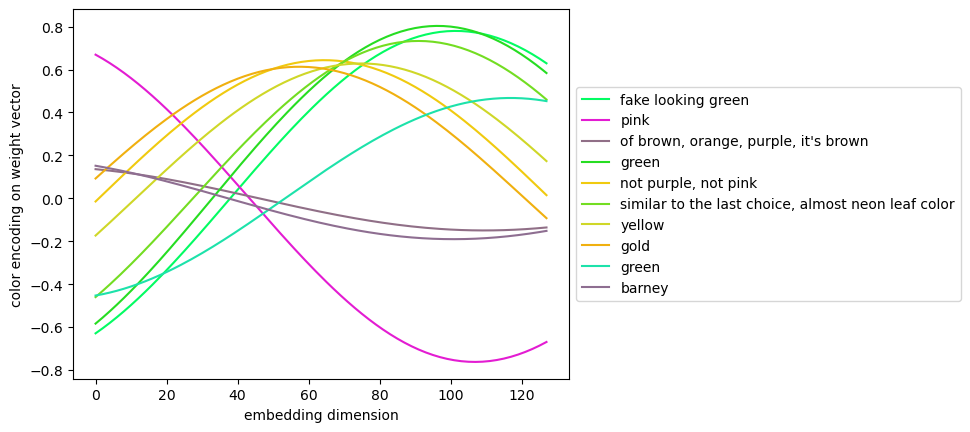

In [72]:
import matplotlib.pyplot as plt
import numpy as np


def visualize(dataset, iterator ) :
    fig, ax = plt.subplots()
    for i in iterator :
        ax.plot(dataset.target_embeddings[i], color=dataset.target_rgbs[i], label=dataset.texts[i])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel("embedding dimension")
    ax.set_ylabel('color encoding on weight vector')
    plt.show()

sample = (  far_train_ds.target_rgbs[0] , far_train_ds.target_embeddings[0], far_train_ds.texts[0]  )

visualize(far_train_ds,range(0,10))


## Keep only texts of length 1
- This could change to an average

In [73]:


W     = [] # words  
X     = [] # llm embeddings
y     = [] # color embeddings
colors = [] # color
for i in range(len(far_train_ds.llm_data)) :
    x = np.asarray(far_train_ds.llm_data[i])
    if x.shape[1]==1:
        W.append(far_train_ds.texts[i])
        colors.append(far_train_ds.target_rgbs[i])
        X.append(np.squeeze(x))
        y.append(far_train_ds.target_embeddings[i])
# print(W)
X = np.asarray(X)
y = np.asarray(y)
print(X.shape)
print(y.shape)

(5648, 768)
(5648, 128)


- take a look at the words

In [74]:
print(W)

['green', 'yellow', 'gold', 'green', 'yellow', 'blue', 'gray', 'tan', 'red', 'blue', 'gray', 'green', 'blue', 'green', 'green', 'gray', 'green', 'blue', 'orange', 'green', 'orange', 'green', 'green', 'green', 'brown', 'grey', 'red', 'Blue', 'yellow', 'orange', 'green', 'red', 'green', 'blue', 'yellow', 'green', 'orange', 'blue', 'red', 'green', 'green', 'yellow', 'green', 'grey', 'green', 'red', 'gray', 'RED', 'lime', 'grey', 'green', 'Orange', 'red', 'red', 'green', 'blue', 'yellow', 'blood', 'blue', 'grey', 'Grey', 'green', 'blue', 'red', 'green', 'grey', 'blue', 'green', 'green', 'orange', 'grey', 'tan', 'orange', 'green', 'green', 'green', 'grey', 'grey', 'brown', 'green', 'blue', 'orange', 'red', 'orange', 'sky', 'blue', 'brown', 'Orange', 'blue', 'yellow', 'Brown', 'red', 'green', 'red', 'gray', 'orange', 'blue', 'blood', 'blue', 'blue', 'green', 'blue', 'green', 'red', 'Grey', 'blue', 'blue', 'green', 'grey', 'green', 'orange', 'Red', 'blue', 'blue', 'red', 'grey', 'yellow', 'gr

In [75]:
from torch_autoencoder import TorchAutoencoder
import torch
from torch import nn

class TorchEncoder(TorchAutoencoder):
    # Can change loss function here
    def __init__(self,**base_kwargs):
        super().__init__(**base_kwargs)
        # self.loss = nn.NLLLoss()

    # can build a different model here
    def build_graph(self):
        return nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim*2),
            self.hidden_activation,
            nn.Linear(self.hidden_dim*2, self.hidden_dim),
            self.hidden_activation,
            nn.Linear(self.hidden_dim, self.output_dim))

    # minor variation from TorchAutoencoder base class so that 
    # the output dimention is y  
    def build_dataset(self, X, y=None) :
        # Data prep:
        X = np.array(X)
        self.input_dim = X.shape[1]

        # Dataset:
        X = self.convert_input_to_tensor(X)
        if y is None:
            dataset = torch.utils.data.TensorDataset(X)
        else:
            self.output_dim = y.shape[1]
            y = self.convert_input_to_tensor(y)
            dataset = torch.utils.data.TensorDataset(X, y)
        return dataset

    # the super super class does all the work ( as opposed to the TorchAutoencoder method)
    def fit(self, X, y):
        return super(TorchAutoencoder, self).fit(X,y)


mod = TorchEncoder(hidden_dim=EMB_SIZE*2 )
mod.fit(X,  y)
# y is the target embedding
# y0 is the 0th color
# y1 is the 1st color
y_pred = mod.predict(X)

# run softmax on y_pred vs y0,y1 and y2
# count the number of times the correct color is the highest softmax
# that is the accuracy. R


Stopping after epoch 56. Training loss did not improve more than tol=1e-05. Final error is 0.18233994580805302.

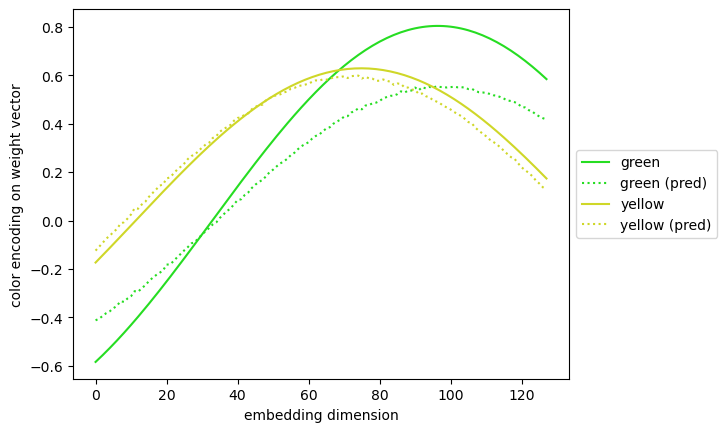

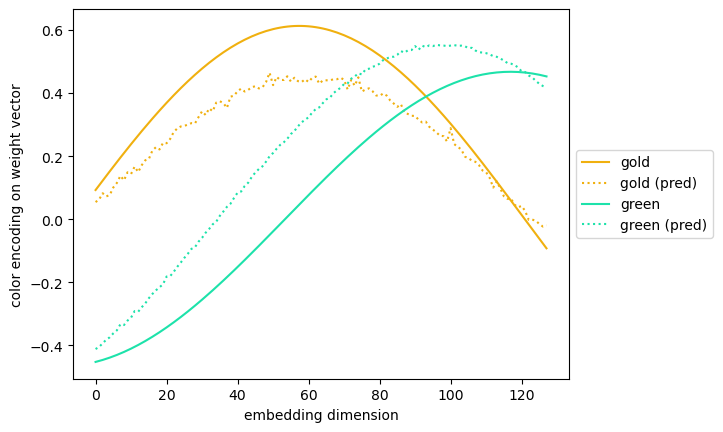

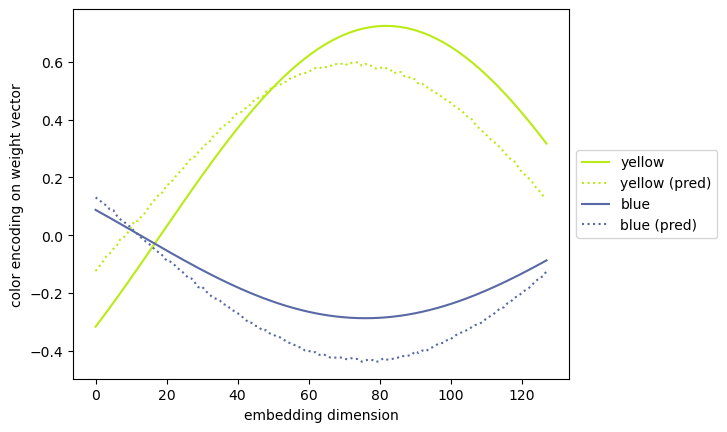

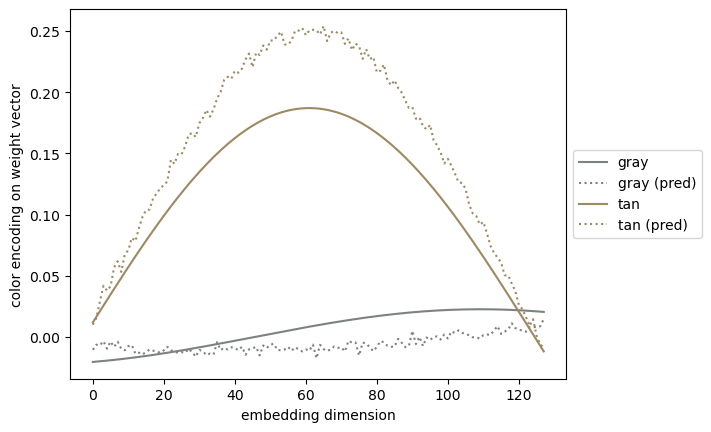

In [79]:
def plot(W,color,y,y_pred, iterator ) :
    fig, ax = plt.subplots()
    for i in iterator :
        ax.plot(y[i],  color=color[i], label=W[i])
        ax.plot(y_pred[i], linestyle='dotted', color=color[i],label=W[i]+ " (pred)")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel("embedding dimension")
    ax.set_ylabel('color encoding on weight vector')
    plt.show()

sample = (  far_train_ds.target_rgbs[0] , far_train_ds.target_embeddings[0], far_train_ds.texts[0]  )

plot(W,colors,y,y_pred,range(0,2))
plot(W,colors,y,y_pred,range(2,4))
plot(W,colors,y,y_pred,range(4,6))
plot(W,colors,y,y_pred,range(6,8))